# Práctica 1: PCA + Clustering 
* Autores: Luis Bueno y Yago Tobio 
* Dataset original: [Aircraft Wildlife Strikes 1990 - 2023 ](https://www.kaggle.com/datasets/dianaddx/aircraft-wildlife-strikes-1990-2023?resource=download)

---

# 1. Preprocesamiento para purificar el dataset

In [1]:
# * Librerías 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE

import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px

In [2]:
# Define la ruta del archivo Excel
ruta_archivo = 'STRIKE_REPORTS.csv'

# Carga el archivo Excel en un DataFrame de pandas
df = pd.read_csv(ruta_archivo)

/var/folders/hs/d248yjt91hj682bsqhd1bv0m0000gn/T/ipykernel_34539/1240123147.py:5: DtypeWarning: Columns (18,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta_archivo)


In [3]:
df.head()

,INDEX_NR,INCIDENT_DATE,INCIDENT_MONTH,INCIDENT_YEAR,TIME,TIME_OF_DAY,AIRPORT_ID,AIRPORT,LATITUDE,LONGITUDE,...,SIZE,NR_INJURIES,NR_FATALITIES,COMMENTS,REPORTED_NAME,REPORTED_TITLE,SOURCE,PERSON,LUPDATE,TRANSFER
0,608242,6/22/1996,6,1996,NaN,NaN,KSMF,SACRAMENTO INTL,38.69542,-121.59077,...,Medium,NaN,NaN,/Legacy Record=100001/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,12/20/2007,False
1,608243,6/26/1996,6,1996,NaN,NaN,KDEN,DENVER INTL AIRPORT,39.85841,-104.66700,...,Medium,NaN,NaN,/Legacy Record=100002/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,12/20/2007,False
2,608244,7/1/1996,7,1996,NaN,NaN,KOMA,EPPLEY AIRFIELD,41.30252,-95.89417,...,Medium,NaN,NaN,/Legacy Record=100003/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,12/20/2007,False
3,608245,7/1/1996,7,1996,NaN,NaN,KIAD,WASHINGTON DULLES INTL ARPT,38.94453,-77.45581,...,Medium,NaN,NaN,/Legacy Record=100004/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,12/20/2007,False
4,608246,7/1/1996,7,1996,NaN,NaN,KLGA,LA GUARDIA ARPT,40.77724,-73.87261,...,Medium,NaN,NaN,/Legacy Record=100005/,REDACTED,REDACTED,Air Transport Report,Air Transport Operations,12/20/2007,False


In [4]:

# * Seleccionamos las categorías que deseamos conservar en nuestro dataset
CATEGORICAL_COLUMNS = ['TIME_OF_DAY', 'AIRCRAFT', 'AC_MASS', 'PHASE_OF_FLIGHT', 'SPECIES', 'STATE', 'NUM_STRUCK'] 
NUMERICAL_COLUMNS = ['INCIDENT_YEAR', 'HEIGHT', 'SPEED', 'DISTANCE', 'COST_REPAIRS_INFL_ADJ', 'COST_OTHER_INFL_ADJ']
TOTAL_COLUMNS = CATEGORICAL_COLUMNS + NUMERICAL_COLUMNS

In [24]:

# *  Elimina filas donde cualquiera de las columnas especificadas tenga un valor NaN
df = df.dropna(subset=['HEIGHT', 'SPEED', 'DISTANCE', 'NUM_STRUCK'])

# * Sumamos las columnas para hallar el coste total. 
#df['COST_INFL_ADJ'] = df['COST_REPAIRS_INFL_ADJ'] + df['COST_OTHER_INFL_ADJ']

# * Seleccionamos únicamente las columnas deseadas para nuestro analisis, PCA y Clustering
df = df[TOTAL_COLUMNS]
df.head()

,TIME_OF_DAY,AIRCRAFT,AC_MASS,PHASE_OF_FLIGHT,SPECIES,STATE,NUM_STRUCK,INCIDENT_YEAR,HEIGHT,SPEED,DISTANCE,COST_INFL_ADJ
5,Day,B-727-100,4.0,Take-off Run,Unknown bird - medium,TX,1,1991,0.0,100.0,0.0,NaN
11,Day,DC-9,4.0,Landing Roll,Unknown bird - small,GA,2-10,1990,0.0,100.0,0.0,NaN
13,Day,MD-11,4.0,Landing Roll,Unknown bird - small,TX,1,1993,0.0,120.0,0.0,NaN
16,Day,MD-80,4.0,Landing Roll,American kestrel,CA,1,1990,0.0,125.0,0.0,NaN
18,NaN,B-757-200,4.0,Take-off Run,Unknown bird - medium,CA,11-100,1995,0.0,140.0,0.0,NaN


Debido al voluminoso tamaño de nuestro conjunto de datos original, consideramos que es una práctica recomendable almacenar los datos ya depurados que emplearemos a lo largo del proyecto en un nuevo archivo con formato .xlsx

In [25]:
# Nombre del archivo de salida
nombre_archivo_salida = 'datos_limpios.xlsx'
df.to_excel(nombre_archivo_salida, index=False)

In [26]:
# Define la ruta del archivo Excel
ruta_archivo = 'datos_limpios.xlsx'

# Carga el archivo Excel en un DataFrame de pandas
df = pd.read_excel(ruta_archivo)
df.head()

,TIME_OF_DAY,AIRCRAFT,AC_MASS,PHASE_OF_FLIGHT,SPECIES,STATE,NUM_STRUCK,INCIDENT_YEAR,HEIGHT,SPEED,DISTANCE,COST_INFL_ADJ
0,Day,B-727-100,4.0,Take-off Run,Unknown bird - medium,TX,1,1991,0,100,0.0,NaN
1,Day,DC-9,4.0,Landing Roll,Unknown bird - small,GA,2-10,1990,0,100,0.0,NaN
2,Day,MD-11,4.0,Landing Roll,Unknown bird - small,TX,1,1993,0,120,0.0,NaN
3,Day,MD-80,4.0,Landing Roll,American kestrel,CA,1,1990,0,125,0.0,NaN
4,NaN,B-757-200,4.0,Take-off Run,Unknown bird - medium,CA,11-100,1995,0,140,0.0,NaN


In [27]:
print(df['COST_INFL_ADJ'].value_counts())

#for column in NUMERICAL_COLUMNS:
#    df[column] = pd.to_numeric(df[column].astype(str).str.replace(',', ''), errors='coerce')

COST_INFL_ADJ
1,255.001,255.00       3
136,300.0027,260.00    2
22,880.003,432.00      2
1,274.001,274.00       2
59,650.0035,790.00     2
                      ..
46,970.0016,104.00     1
288,530.0013,420.00    1
26,840.006,710.00      1
93,940.0048,312.00     1
5,000.0010,000.00      1
Name: count, Length: 684, dtype: int64


# 2.Analisis Explicativo del dataset (EDA): 

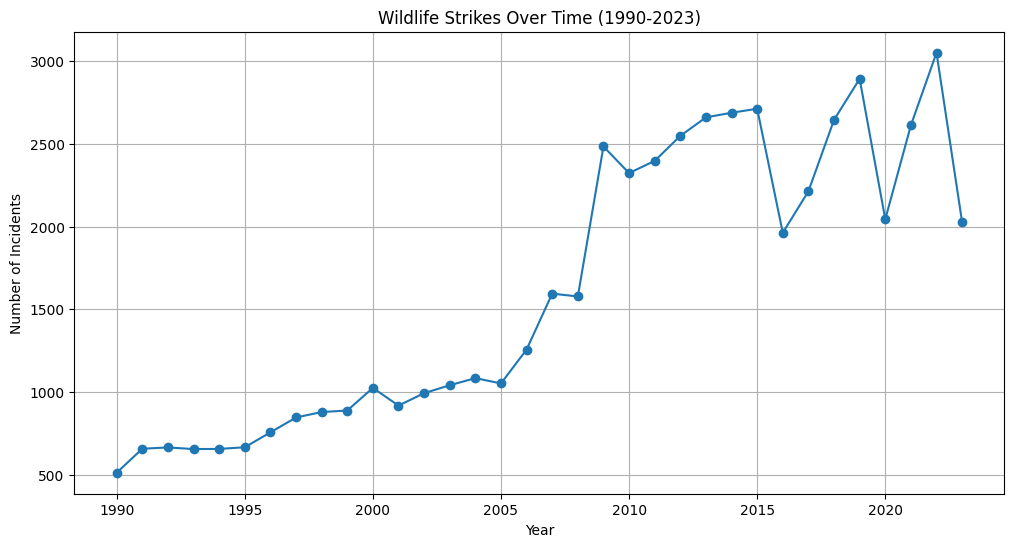

In [8]:
# Assuming df is your DataFrame after loading the dataset
# Plotting incidents over the years
yearly_trends = df.groupby('INCIDENT_YEAR').size()

plt.figure(figsize=(12, 6))
yearly_trends.plot(kind='line', marker='o')
plt.title('Wildlife Strikes Over Time (1990-2023)')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.grid(True)
plt.show()


In [9]:
state_accidents = df.groupby('STATE').size().reset_index(name='counts')
fig = px.choropleth(state_accidents,
                    locations='STATE', 
                    locationmode="USA-states", 
                    color='counts', 
                    color_continuous_scale="Viridis",
                    scope="usa",
                    labels={'counts':'Number of Incidents'}
                   )

fig.update_layout(title_text='Wildlife Strikes by State in the USA (1990-2023)')
fig.show()

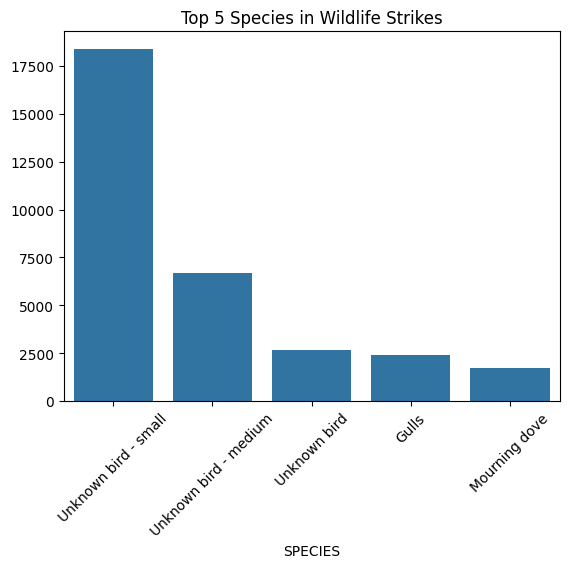

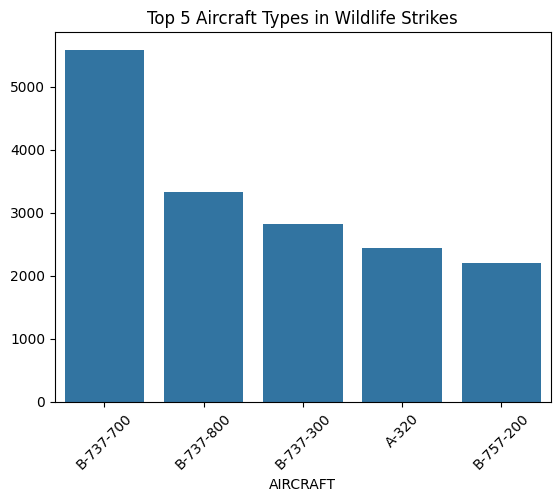

In [10]:
# Top 5 species involved in strikes
top_species = df['SPECIES'].value_counts().head(5)
sns.barplot(x=top_species.index, y=top_species.values)
plt.title('Top 5 Species in Wildlife Strikes')
plt.xticks(rotation=45)
plt.show()

# Aircraft types most involved in strikes
top_aircraft = df['AIRCRAFT'].value_counts().head(5)
sns.barplot(x=top_aircraft.index, y=top_aircraft.values)
plt.title('Top 5 Aircraft Types in Wildlife Strikes')
plt.xticks(rotation=45)
plt.show()


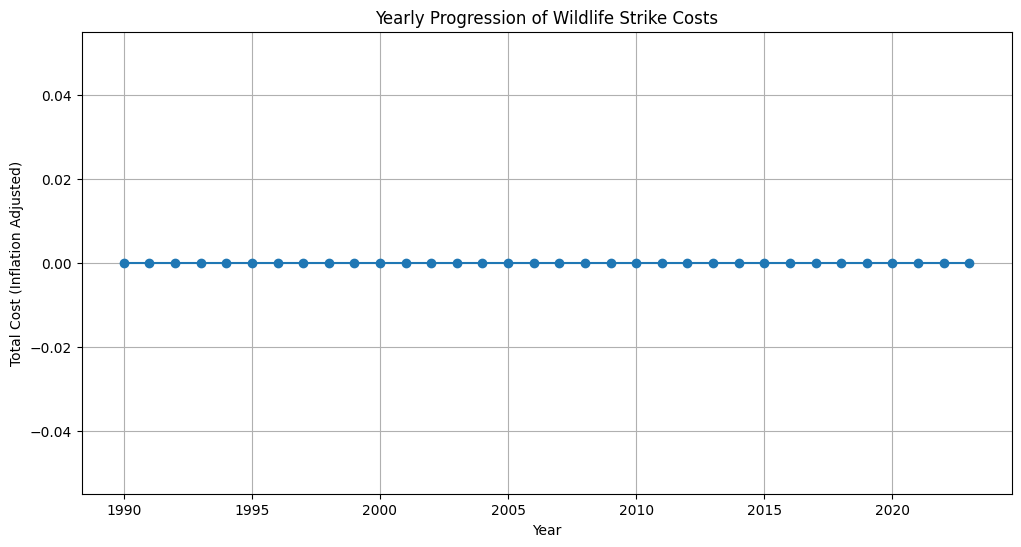

In [18]:
yearly_costs = df.groupby('INCIDENT_YEAR')['COST_INFL_ADJ'].sum()

plt.figure(figsize=(12, 6))
yearly_costs.plot(kind='line', marker='o')
plt.title('Yearly Progression of Wildlife Strike Costs')
plt.xlabel('Year')
plt.ylabel('Total Cost (Inflation Adjusted)')
plt.grid(True)
plt.show()

In [19]:
overall_cost = df['COST_INFL_ADJ'].sum()
print(f"Overall cost (Inflation Adjusted): {overall_cost}")

Overall cost (Inflation Adjusted): 0.0


In [13]:
# Análisis de la distribución de categorías
for i, column in enumerate(CATEGORICAL_COLUMNS, 1): 
    print(f"Column: {column}")
    print(df[column].value_counts())
    print("\n")

Column: TIME_OF_DAY
TIME_OF_DAY
Day      33688
Night    14241
Dusk      2575
Dawn      2016
Name: count, dtype: int64


Column: AIRCRAFT
AIRCRAFT
B-737-700                5586
B-737-800                3331
B-737-300                2816
A-320                    2438
B-757-200                2209
                         ... 
F-15E                       1
NORTH AMERICAN              1
CESSNA LC-41                1
BRITISH AEROSPACE           1
NORTH AMERICAN OV-10A       1
Name: count, Length: 453, dtype: int64


Column: AC_MASS
AC_MASS
4.0    37625
3.0     9633
1.0     3572
2.0     3526
5.0      399
Name: count, dtype: int64


Column: PHASE_OF_FLIGHT
PHASE_OF_FLIGHT
Approach        22484
Take-off Run    12474
Landing Roll    11943
Climb            7210
Descent           494
Taxi              151
Local             138
Parked             33
En Route            1
Name: count, dtype: int64


Column: SPECIES
SPECIES
Unknown bird - small     18384
Unknown bird - medium     6704
Unknown bird  

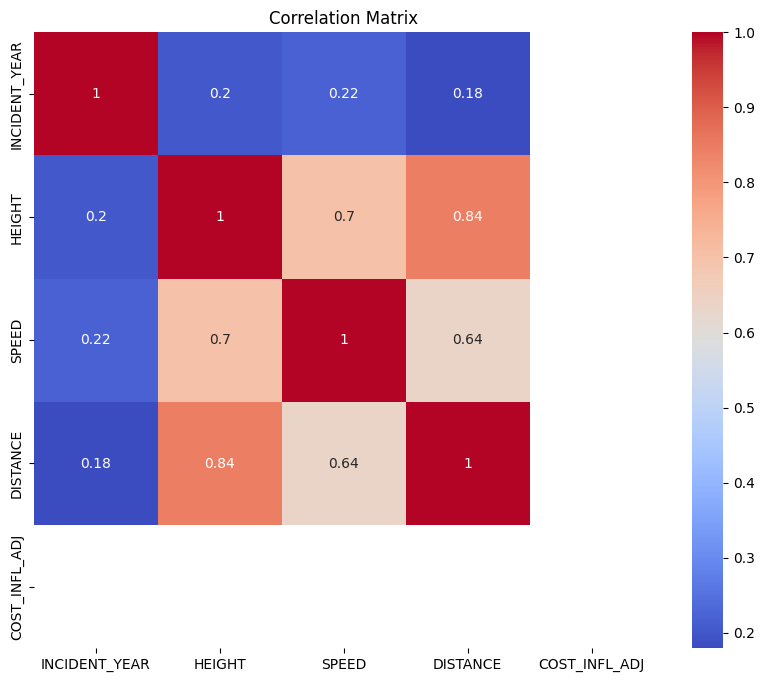

In [17]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[NUMERICAL_COLUMNS].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

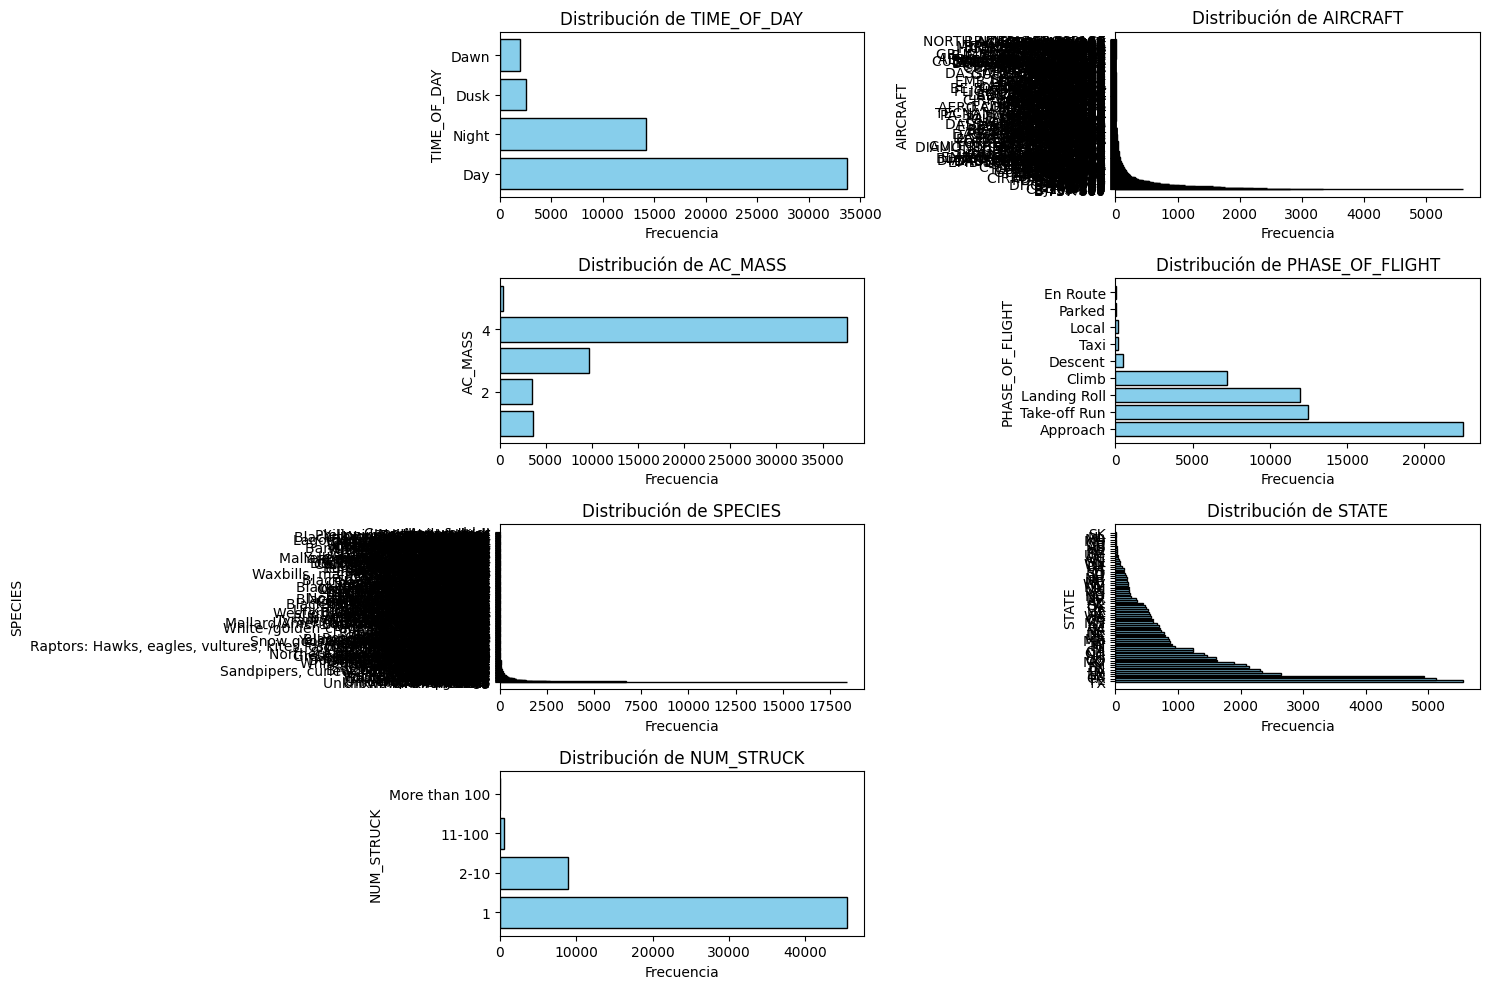

In [12]:

# * Análisis de la distribución de columnas categóricas 
plt.figure(figsize=(15, 10))

for i, column in enumerate(CATEGORICAL_COLUMNS, 1):
    # Calculate the frequencies of each category
    value_counts = df[column].value_counts()
    # Create a horizontal bar chart
    plt.subplot(4, 2, i)  # Adjust the grid dimensions as needed
    plt.barh(value_counts.index, value_counts, color='skyblue', edgecolor='black')
    plt.title(f'Distribución de {column}')
    plt.xlabel('Frecuencia')
    plt.ylabel(column)
    
plt.tight_layout()
plt.show()


De las graficas de arriba, podemos observar que existe un gran desfase de clases - particularmente con la columna de SPECIES, AIRPORT_ID y AIRCRAFT. 
Con el fin de equilibrar las clases y seleccionar los datos más relevantes, vamos a generar una tabla la cual cojan datos de hasta el cuartil 75 dentro de toda la distribución y evitar casos extremos. 

Para aquellas otras categorías como AC_MASS, PHASE_OF_FLIGHT, TIME_OF_DAY, procederemos a equilibrar las clases mediante SMOTE. 